**Normal Distribution**  
$Pr(x|\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp{(-\frac{(x-\mu)^2}{2\sigma^2})}$  
$\theta = {\mu, \sigma^2}$  

To model a complex probability density function over the variable x, we will introduc a hidden or latent variable h.  
$Pr(x|\theta) = \int Pr(x,h|\theta) dh$  
This fomulations has the advantage that will result in a neat closed form solution. We use Expectation maximization algorithm to approach  
$\hat{\theta}=\underset{\theta}{argmax}[\sum_{i=1}^{I}{log[\int{Pr(x_i,h_i|\theta)dh_i}]}]$  
For each i, let Q be some distribution over h. $\sum_{h}Q_i{(h)}=1$  
$\sum_{i}{log p(x^{(x_i)}|\theta)} = \sum_{i}log\sum_{h^{(i)}}p(x^{(i)}, h^{(i)}|\theta)$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$= \sum_{i}log\sum_{h^{(i)}}Q_{i}(h^{(i)})\frac{p(x^{(i)}, h^{(i)}|\theta)}{Q_{i}(h^{(i)})}$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\geq  \sum_{i}\sum_{h^{(i)}}Q_{i}(h^{(i)})log\left (\frac{p(x^{(i)}, h^{(i)}|\theta)}{Q_{i}(h^{(i)})}\right )$  

**Theorem. Let f be a convex function, and let X be a random variable.**  
Then:  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$E[f(X)]\leq f(EX).$  
Moreover, if f is strictly convex, then E[f(X)] = f(EX) holds true if and
only if X = E[X] with probability 1 (i.e., if X is a constant)  

**For E step:**  
$Q_i(h^{(i)}) = \frac{p(x^{((i))},h^{((i))}|\theta)}{p(x^{(i)}|\theta)} = p(h^{(i)}|x^{(i)},\theta) = \frac{\lambda_{k}Norm_{x_{i}}\left [\mu_{k},\sigma_{k} \right ]}{\sum_{j=1}^{K}{\lambda_{j}Norm_{x_i}[\mu_j,\sigma_j]}} = r_{ik}$  
**For M step:**  
$\theta^{(t+1)} = \underset{\theta}{argmax}\sum_i\sum_{h^{(i)}}Q_{i}(h^{(i)})log\left ( \frac{p(x^{(i)}, h^{(i)}|\theta)}{Q_{i}(h^{(i)})} \right ) = \underset{\theta}{argmax}\left [ \sum_i\sum_{k}r_{ik}Norm_{x_i}[\mu_j,\sigma_j] ) \right ]$  
$\lambda_{k}^{[t+1]} = \frac{\sum_{i=1}^{I}r_{ik}}{\sum_{j=1}^{K}\sum_{i=1}^{I}r_{ij}}$  
$\mu_k^{[t+1]} = \frac{\sum_{i=1}^{I}r_{ik}x_i}{\sum_{i=1}^{I}r_{ik}}$  
$\sigma_k^{[t+1]} = \frac{\sum_{i=1}^{I}r_{ik} (x_i - \mu_k^{[t+1]})(x_i-\mu_k^{[t+1]})^T}{\sum_{i=1}^{I}r_{ik}}$

[(-6.0, 6.0), (-1.0, 9.0)]

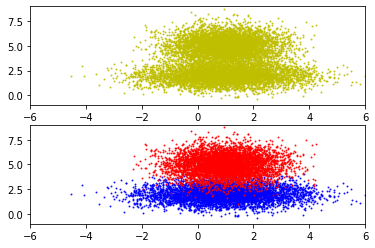

In [1]:
import matplotlib.pyplot as plt
import numpy as np


mean_1 = [1, 2]
cov_1 = [[2, 0], [0, 0.5]]
mean_2 = [1, 5]
cov_2 = [[1, 0], [0, 1]]
N = 5000
X0 = np.random.multivariate_normal(mean_1, cov_1, N)
X1 = np.random.multivariate_normal(mean_2, cov_2, N)

# each column is a datapoint
fig, axs = plt.subplots(2)
X = np.concatenate((X0, X1), axis = 0)
axs[0].plot(X[:, 0], X[:, 1], 'yo', markersize = 1, alpha = .8)
axs[1].plot(X0[:, 0], X0[:, 1], 'bo', markersize = 1, alpha = .8)
axs[1].plot(X1[:, 0], X1[:, 1], 'ro', markersize = 1, alpha = .8)
x_range = (-6, 6)
y_range = (-1, 9)
axs[0].set(xlim=x_range, ylim=y_range)
axs[1].set(xlim=x_range, ylim=y_range)
# axs[0].axis('off')
# axs[1].axis('off')

In [2]:
from scipy import stats

def fit_mog(X, K, precision):
    lamda = np.ones((K, 1), dtype=float) / K

    # Initialize the values in mu to K randomly chosen unique datapoints.
    mu = np.random.permutation(X)[0:K,:]

    # Initialize the variances in sig to the variance of the dataset.
    sig = []
    I, dimensionality = X.shape
    dataset_mean = np.sum(X, axis=0) / I
    dataset_variance = np.zeros((dimensionality, dimensionality), dtype=float)
    for i in range(I):
        mat = (X[i,:] - dataset_mean)[np.newaxis]
        mat = mat.T @ mat
        dataset_variance = dataset_variance + mat

    dataset_variance = dataset_variance / I
        
    for i in range(K):
        sig.append(dataset_variance)
    
    # The main loop.
    iterations = 0
    previous_L = 1000000 #Just a random initialization
    
    while True:
        # Expectation step.
        l = np.zeros((I, K))
        r = np.zeros((I, K))
        
        # Compute the numerator of Bayes' rule.
        for k in range (K):
            l[:,k] = lamda[k] * stats.multivariate_normal.pdf(X, mu[k,:], sig[k])
            
        s = np.sum(l, axis=1)
        for i in range(I):
            r[i,:] = l[i,:] / s[i]
        # Maximization step.
        r_summed_rows = np.sum(r,axis=0)
        r_summed_all = np.sum(np.sum(r,axis=0), axis=0)
        for k in range(K):
            
            # Update lambda.
            lamda[k] = r_summed_rows[k] / r_summed_all       

            # Update mu
            new_mu = np.zeros((1,dimensionality), dtype=float)
            for i in range(I):
                new_mu = new_mu + r[i,k]*X[i,:]
                
            mu[k,:] = new_mu / r_summed_rows[k]
            # Update sigma.
            new_sigma = np.zeros((dimensionality,dimensionality), dtype=float)
            for i in range(I):
                mat = (X[i,:] - mu[k,:])[np.newaxis]
                mat = r[i,k] * mat.T @ mat
                new_sigma = new_sigma + mat                
            sig[k] = new_sigma / r_summed_rows[k]
        # Compute the log likelihood L.
        temp = np.zeros((I,K), dtype=float)
        
        for k in range(K):
            temp[:, k] = lamda[k] * stats.multivariate_normal.pdf(X, mu[k,:], sig[k])

        temp = np.sum(temp, axis=1)
        temp = np.log(temp)        
        L = np.sum(temp, axis=0)  
        iterations = iterations + 1
        if (abs(L - previous_L) < precision):
            break
        previous_L = L
    return lamda, mu, sig
lamda1, mu1, sig1 = fit_mog(X, 1, 0.02)
lamda2, mu2, sig2 = fit_mog(X, 2, 0.02)
lamda3, mu3, sig3 = fit_mog(X, 3, 0.02)


In [3]:
def prepare_mog_model(lamda, mu, sig, n):
    # Compute the first Gaussian as a matrix.
    mog = 0
    K, _ = mu.shape
    for index in range(K):
        # Now combine the two Gaussians with the corresponding weights in lambda,
        # to obtain the final mixture of Gaussians.
        temp = stats.multivariate_normal.pdf(x_y_matrix, mu[index,:], sig[index])
        gaussian = temp.reshape(n, n)
        mog += lamda[index]*gaussian
    return mog


In [4]:
# Plot the mixture of Gaussians as contour plot.
# Create the x-y matrix.
X_1_vals = np.arange(-10, 10, 0.01)
X_2_vals = np.arange(-10, 10, 0.01)
XX, YY = np.meshgrid(X_1_vals, X_2_vals)
size_ = XX.size
x = XX.reshape(size_,1)
y = YY.reshape(size_,1)
x_y_matrix = np.hstack((x,y))
n = len(XX)

mog1 = prepare_mog_model(lamda1, mu1, sig1, n)
mog2 = prepare_mog_model(lamda2, mu2, sig2, n)
mog3 = prepare_mog_model(lamda3, mu3, sig3, n)


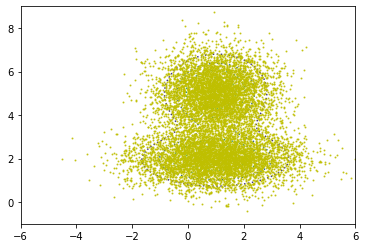

In [5]:
# Create the contour plot.

plt.plot(X[:, 0], X[:, 1], 'yo', markersize = 1, alpha = .8)
plt.xlim(-6,6)
plt.ylim(-1,9)
# plt.contour(XX,YY,mog1)
# plt.contour(XX,YY,mog2, linestyles='dashed')
plt.contour(XX,YY,mog3, linestyles='dotted')